# Iniciales

## 🧠 Project Context and Dataset Origin

This section introduces the dataset used to build the file **`pose_features_L.csv`**, which serves as the foundation for the *Posture Classifier* — an exploratory component of the broader **Guardian Eye** system for fall detection.

---

### 🛰️ Dataset Origin

The initial data was obtained from a **custom dataset on Roboflow**, which includes annotated images of people in two categories:
- **`Normal`** – individuals standing, walking, or sitting normally.
- **`Fall`** – individuals lying on the ground or captured during a fall.

Each image represents a static frame extracted from short surveillance-like videos recorded from different camera angles and lighting conditions.

---

### 🤖 Feature Extraction Process

To generate the structured dataset (`pose_features_L.csv`), a dedicated Python script(`extract_pose_features.py`) was developed that combines:
1. **YOLO Pose (Large variant)** – to estimate 17 body keypoints per person following the COCO format.  
2. **Custom geometric feature computation** – to derive angles, distances, aspect ratios, and positional metrics from those keypoints.

During this process, for each detected person in an image:
- The model calculated a set of geometric and anatomical measurements.
- Each record was saved as a row in the resulting CSV, with its corresponding class label (`Fall` or `Normal`).

---

### ⚠️ Detection Limitations

Not all images in the Roboflow dataset yielded valid pose estimations:
- In some cases, **no person was detected** (due to occlusion, distance, or low contrast).
- In others, **the model detected a person but with incomplete keypoints**, preventing the calculation of essential features such as `angle_deg` or `aspect_pose`.

These limitations resulted in some rows with missing values (`NaN`) in the CSV — which will later be handled in the **Data Cleaning** phase.

---

### 🧩 Exploratory Model Purpose

This model is **exploratory** and complements other detection approaches in the Guardian Eye system:
- While object-detection-based models (like YOLOv12 fall detectors) focus on recognizing a “falling person” pattern,
- The *Posture Classifier* analyzes **body geometry and pose-derived metrics** to evaluate the **final posture** of an individual.

The objective of this stage is to:
1. Identify which pose-based features are informative for distinguishing between `Fall` and `Normal`.
2. Determine whether a supervised learning model can achieve meaningful predictive accuracy based solely on **pose geometry**.

---

### 📈 Next Steps

1. Understand the composition and structure of the extracted dataset (`pose_features_L.csv`).  
2. Clean and prepare the data to retain only valid samples with complete pose information.  
3. Perform EDA to identify which features are most relevant for the classification task.  
4. Train and evaluate a supervised model as a proof of concept for pose-based fall detection.

---

🧭 This exploration helps determine whether pose-derived features alone can effectively detect falls — serving as an analytical complement to other detection methods within the Guardian Eye architecture.


In [20]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib

## 🧩 Why Are There 39 Columns in the CSV?

The file **`pose_features_L.csv`** represents an *intermediate feature-engineering dataset* generated during the YOLO Pose extraction process.  
It includes **all the raw and derived variables** that could potentially describe a human posture or body geometry.  
This comprehensive extraction ensures that every measurable aspect of a person’s position, proportions, and motion can later be analyzed during the EDA phase to determine which variables truly contribute to fall detection.

---

### 🧠 Purpose

This dataset was designed to collect the **full spectrum of geometric, positional, and anatomical features** from each detected person in an image.  
The goal at this stage is *not yet modeling*, but rather **understanding the data**, identifying relationships among features, and exploring which patterns are most informative for distinguishing human postures.

---

### 📋 Column Categories

| Category | Example Columns | Description / Purpose |
|-----------|-----------------|------------------------|
| **Identification** | `image`, `split`, `class_id`, `class_name` | Metadata to trace dataset origin, data splits, and label type. |
| **Image Dimensions** | `img_W`, `img_H` | Frame resolution — useful for normalization and contextual diagnostics. |
| **Bounding Box (YOLO)** | `x_center`, `y_center`, `width`, `height`, `aspect_bbox`, `area_bbox` | Object geometry derived from detection boxes; basic 2D spatial representation. |
| **Pose Geometry (YOLO Pose)** | `pose_w`, `pose_h`, `pose_area`, `angle_deg`, `aspect_pose` | Overall body structure — width, height, and orientation of the detected pose. |
| **Anatomical Proportions** | `shoulder_width`, `hip_width`, `shoulder_hip_ratio`, `torso_len`, `body_len_est` | Estimated distances between key joints; indicators of body proportion and compression. |
| **Spatial Dispersion** | `var_x`, `var_y`, `std_x`, `std_y` | Statistical spread of detected keypoints across X and Y coordinates. |
| **Relative Position** | `center_y_rel`, `head_rel_height` | Position of the detected person within the frame; helps to identify individuals closer to the ground. |
| **Limb Angles** | `thigh_angle_L`, `thigh_angle_R`, `shank_angle_L`, `shank_angle_R`, `upperarm_L`, `upperarm_R` | Biomechanical articulation angles of the limbs — key to understanding body posture. |
| **Pose Confidence** | `num_kp_vis`, `mean_vis` | Indicates how many keypoints were visible and their average detection confidence. |
| **Temporal / Motion Derivatives** | `vy_hps` | Vertical velocity proxy — used for video analysis, often empty in static datasets. |

---

### 📊 Summary

- **Total columns:** 39  
- The dataset contains both *core numeric features* and *contextual metadata*.  
- Around **33 columns** are numeric and suitable for exploration and modeling after cleaning.  
- The remaining columns provide **identification, labeling, or contextual information**, necessary for traceability but not directly predictive.  

---

🧩 At this stage, the goal is to **analyze and understand all 39 available variables** to determine their distributions, correlations, and potential relevance for the posture classification problem.


In [22]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Integrador/fall_opp/pose_features_L.csv")
print(df.shape)
df.head()

(6127, 39)


,split,image,class_id,class_name,img_W,img_H,x_center,y_center,width,height,...,thigh_angle_L,thigh_angle_R,shank_angle_L,shank_angle_R,upperarm_L,upperarm_R,num_kp,num_kp_vis,mean_vis,vy_hps
0,train,train/images/ch02_cam2_f000424_lbl1_jpg.rf.755...,0,Fall,720,480,0.412500,0.397917,0.169444,0.287500,...,9.910022,21.643320,78.272708,78.096915,8.907376,1.726237,17.0,17.0,0.787059,NaN
1,train,train/images/ch13_cam5_f000735_lbl0_jpg.rf.09b...,1,Normal,720,480,0.409472,0.658875,0.230556,0.200312,...,24.092718,49.081813,76.585999,61.718691,42.330182,34.748814,17.0,17.0,0.704049,NaN
2,train,train/images/ch02_cam3_f000374_lbl0_jpg.rf.883...,1,Normal,720,480,0.385417,0.315625,0.106944,0.364583,...,1.767262,30.257901,20.449526,3.691285,3.421220,19.974108,17.0,17.0,0.779122,NaN
3,train,train/images/ch13_cam4_f000706_lbl0_jpg.rf.51c...,1,Normal,720,480,0.454208,0.258833,0.166000,0.104812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,train,train/images/ch19_cam8_f000583_lbl1_jpg.rf.df4...,0,Fall,720,480,0.489458,0.338813,0.245597,0.156792,...,62.380926,57.357943,79.406835,75.377118,22.083363,24.725771,17.0,17.0,0.489553,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   split               6127 non-null   object 
 1   image               6127 non-null   object 
 2   class_id            6127 non-null   int64  
 3   class_name          6127 non-null   object 
 4   img_W               6127 non-null   int64  
 5   img_H               6127 non-null   int64  
 6   x_center            6127 non-null   float64
 7   y_center            6127 non-null   float64
 8   width               6127 non-null   float64
 9   height              6127 non-null   float64
 10  aspect_bbox         6127 non-null   float64
 11  area_bbox           6127 non-null   float64
 12  angle_deg           5606 non-null   float64
 13  aspect_pose         5606 non-null   float64
 14  pose_w              5606 non-null   float64
 15  pose_h              5606 non-null   float64
 16  pose_a

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
class_id,6127.0,0.500571,0.500040,0.000000,0.000000,1.000000,1.000000,1.000000
img_W,6127.0,720.000000,0.000000,720.000000,720.000000,720.000000,720.000000,720.000000
img_H,6127.0,480.000000,0.000000,480.000000,480.000000,480.000000,480.000000,480.000000
x_center,6127.0,0.497775,0.147673,0.054167,0.404861,0.474306,0.590278,0.954569
y_center,6127.0,0.420008,0.129958,0.108333,0.325667,0.406250,0.511458,0.787500
width,6127.0,0.162963,0.072456,0.048611,0.108333,0.144444,0.201389,0.494444
height,6127.0,0.286760,0.104662,0.050396,0.208333,0.275312,0.364583,0.689583
aspect_bbox,6127.0,0.675792,0.463816,0.168724,0.337973,0.490954,0.880462,4.510314
area_bbox,6127.0,0.046024,0.024847,0.004605,0.026756,0.042060,0.059051,0.168565
angle_deg,5606.0,28.726703,26.222392,0.009581,7.199828,18.174360,46.964225,89.992245


## 🧹 Data Cleaning and Preparation

Before performing the Exploratory Data Analysis (EDA), it is essential to ensure that the dataset contains only meaningful and valid information.  
The raw file `pose_features_L.csv` includes auxiliary columns used during feature extraction that are **not directly useful for modeling** or may contain **missing values** due to failed pose detections.

---

### ⚙️ Cleaning Criteria

1. **Remove non-informative or redundant columns:**
   - `vy_hps`: Derived vertical velocity (mostly empty since images are static).
   - `class_id`: Numeric class code — redundant because `class_name` already identifies the label.
   - `img_W`, `img_H`: Image dimensions — irrelevant for model learning and may introduce bias.

2. **Filter out rows without valid pose detection:**
   - The features `angle_deg` and `aspect_pose` are core indicators of body posture.  
     If either of these is missing (`NaN`), it means the YOLO Pose model failed to detect enough keypoints to describe the person’s pose.

---

In [25]:
drop_cols = ["vy_hps", "class_id", "img_W", "img_H"]
df = df.drop(columns=drop_cols)
df_clean = df.dropna(subset=["angle_deg", "aspect_pose"]).reset_index(drop=True)

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   split               5606 non-null   object 
 1   image               5606 non-null   object 
 2   class_name          5606 non-null   object 
 3   x_center            5606 non-null   float64
 4   y_center            5606 non-null   float64
 5   width               5606 non-null   float64
 6   height              5606 non-null   float64
 7   aspect_bbox         5606 non-null   float64
 8   area_bbox           5606 non-null   float64
 9   angle_deg           5606 non-null   float64
 10  aspect_pose         5606 non-null   float64
 11  pose_w              5606 non-null   float64
 12  pose_h              5606 non-null   float64
 13  pose_area           5606 non-null   float64
 14  var_x               5606 non-null   float64
 15  var_y               5606 non-null   float64
 16  std_x 

# EDA

## 🔍 Exploratory Data Analysis (EDA) Overview

Following the CRISP-ML methodology, the **Exploratory Data Analysis (EDA)** phase aims to build a deep understanding of the dataset created during the feature-extraction stage.  
The goal is to identify the **relationships, patterns, and data quality issues** that will determine which features are most informative for detecting human postures and falls.

---

### 🎯 Objectives of the EDA

1. **Understand the data composition**  
   - Examine class balance (`Fall` vs `Normal`).  
   - Identify missing values and possible data inconsistencies.  

2. **Analyze feature distributions**  
   - Study how geometric and anatomical features vary across the two classes.  
   - Visualize whether certain variables show clear separability between standing and fallen positions.  

3. **Detect correlations and redundancy**  
   - Measure linear relationships among features to identify collinear variables.  
   - Prepare the basis for feature reduction and selection before modeling.  

4. **Assess data reliability**  
   - Inspect `mean_vis` and `num_kp_vis` to evaluate pose-estimation confidence.  
   - Detect outliers caused by poor keypoint detection or incorrect bounding boxes.  

---

### 📊 Key Analytical Questions

- How well balanced is the dataset between the `Fall` and `Normal` categories?  
- Which features exhibit significant differences between these classes?  
- Are there groups of highly correlated variables representing the same concept (e.g., size, height, spread)?  
- How many samples have incomplete pose information or missing keypoints?  
- What is the overall data quality and distribution across camera perspectives or splits (`train`, `valid`, `test`)?  

---

### 🧠 Expected Outcomes

By the end of this phase, we will have:

- A clear understanding of **which features are consistent, reliable, and potentially useful** for the posture classification model.  
- Evidence-based justification for **feature reduction**, keeping only the most informative and interpretable variables.  
- Visual and statistical documentation supporting decisions made in the modeling phase.  

---

🧩 The insights gained here will directly inform the **Feature Selection** and **Modeling** stages that follow, ensuring the classifier is both accurate and explainable.


In [27]:
# Quick numeric overview
print("\nDescriptive statistics (numeric features):")
display(df_clean.describe().T)


Descriptive statistics (numeric features):


,count,mean,std,min,25%,50%,75%,max
x_center,5606.0,0.500883,0.149300,0.054167,0.404861,0.479097,0.595833,0.954569
y_center,5606.0,0.422132,0.132264,0.108333,0.325000,0.409375,0.517708,0.787500
width,5606.0,0.162982,0.073069,0.048611,0.108333,0.144444,0.200000,0.494444
height,5606.0,0.297999,0.100972,0.050458,0.220833,0.285417,0.372917,0.689583
aspect_bbox,5606.0,0.639666,0.438635,0.168724,0.330707,0.454543,0.827153,3.783390
area_bbox,5606.0,0.047675,0.024743,0.005368,0.028906,0.043592,0.060692,0.168565
angle_deg,5606.0,28.726703,26.222392,0.009581,7.199828,18.174360,46.964225,89.992245
aspect_pose,5606.0,1.028489,1.009099,0.142560,0.456267,0.624098,1.237008,11.300341
pose_w,5606.0,86.171608,42.708806,17.561861,56.087875,75.686462,104.216190,325.819214
pose_h,5606.0,110.680460,43.256552,10.622804,77.484924,107.632957,143.848122,285.000763


In [28]:
# Class balance check
print("\nClass distribution:")
print(df_clean["class_name"].value_counts(normalize=True).map("{:.2%}".format))


Class distribution:
class_name
Normal    53.69%
Fall      46.31%
Name: proportion, dtype: object


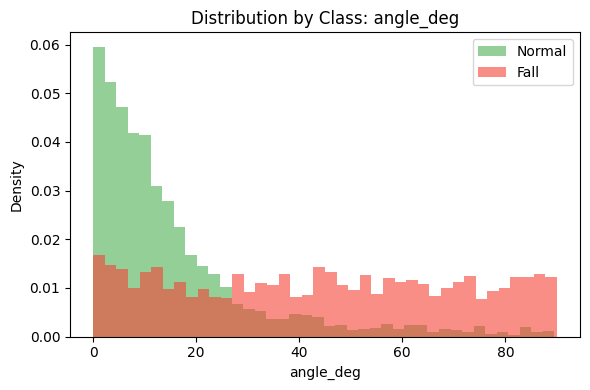

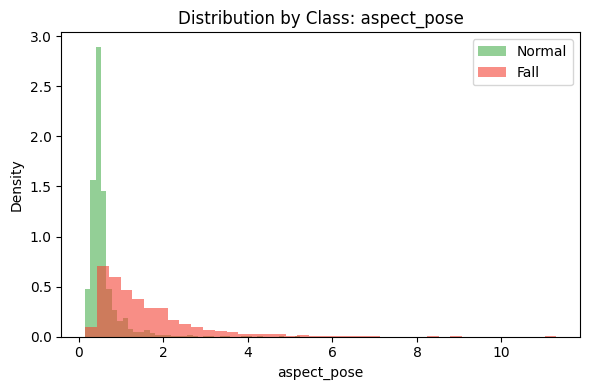

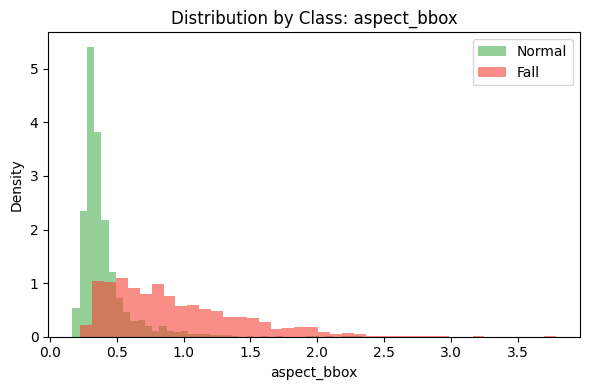

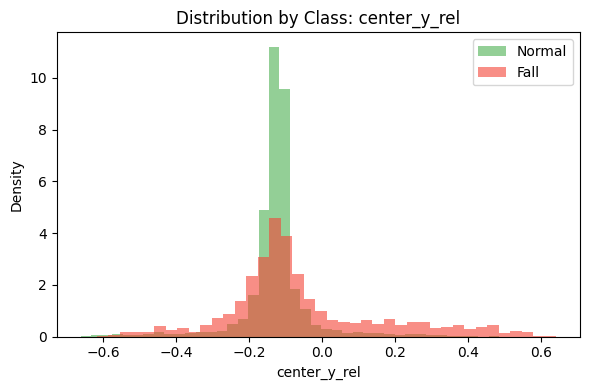

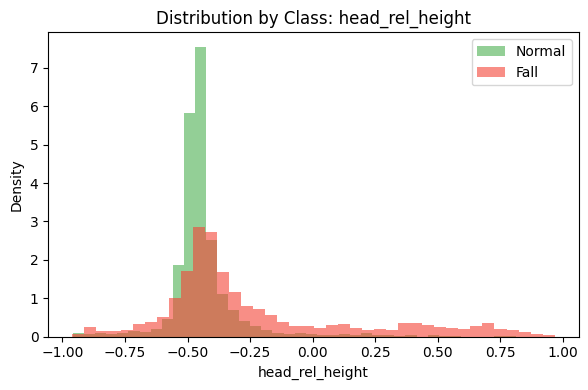

In [29]:
import matplotlib.pyplot as plt

cols_to_plot = ["angle_deg", "aspect_pose", "aspect_bbox", "center_y_rel", "head_rel_height"]

for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    for cls, color in zip(["Normal", "Fall"], ["#4CAF50", "#F44336"]):
        data = df_clean[df_clean["class_name"] == cls][col]
        plt.hist(data, bins=40, alpha=0.6, label=cls, color=color, density=True)
    plt.title(f"Distribution by Class: {col}")
    plt.xlabel(col); plt.ylabel("Density"); plt.legend()
    plt.tight_layout()
    plt.show()

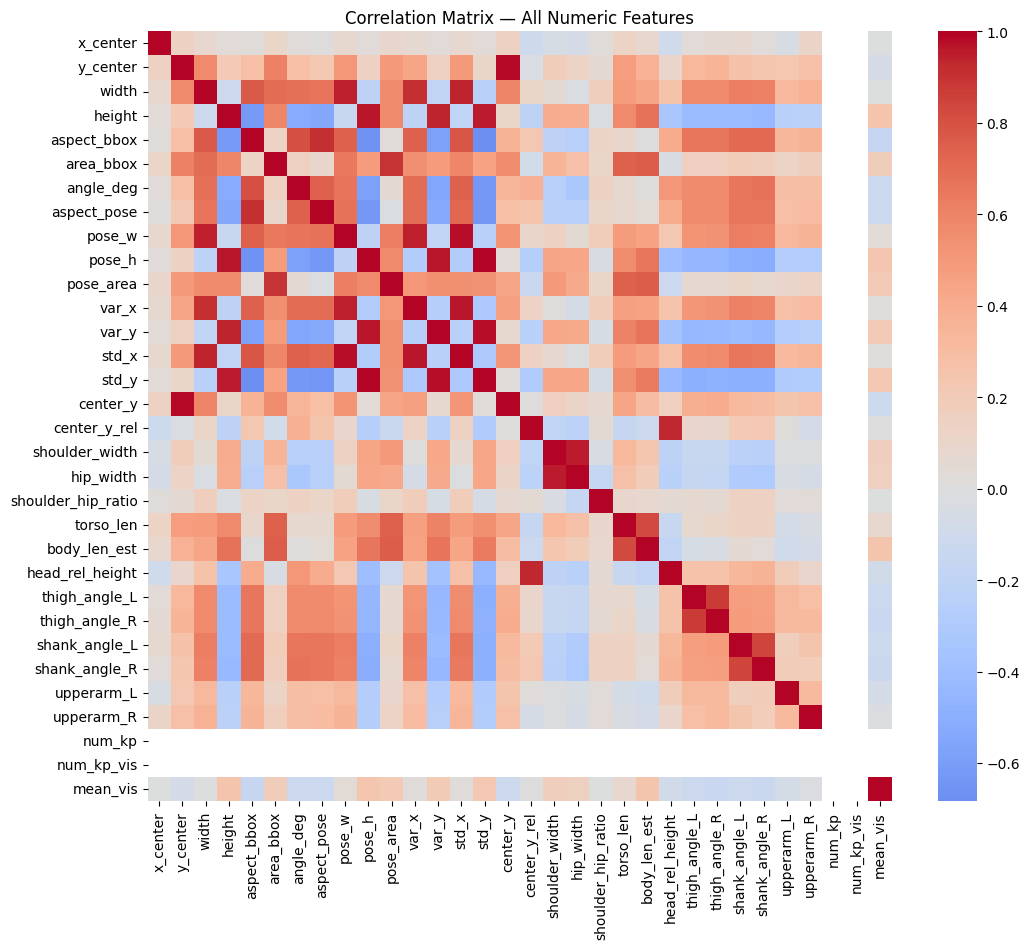

In [30]:
import seaborn as sns
import numpy as np

num_cols = df_clean.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,10))
sns.heatmap(df_clean[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix — All Numeric Features")
plt.show()

## 🧩 Exploratory Data Analysis — Initial Insights

After cleaning the dataset, a total of **5,606 valid samples** were preserved, with a nearly balanced class distribution:
- `Normal`: 53.7%
- `Fall`: 46.3%

This balanced structure ensures that the model will not be biased toward either class during supervised training.

---

### ⚙️ Key Observations from Feature Distributions

#### 1. `angle_deg`
- Shows the **strongest separation** between classes.
- `Normal` postures cluster near **0–15°**, representing vertical alignment (standing).
- `Fall` postures show a flatter distribution up to **90°**, indicating horizontal orientations.
➡️ *Interpretation:* The torso angle relative to the vertical axis is a **primary discriminant** feature for fall detection.

#### 2. `aspect_pose`
- Reflects the **width-to-height ratio** of the detected skeleton.
- `Normal` postures are concentrated near **0.3–0.8**, while `Fall` extends beyond **1.5**.
➡️ *Interpretation:* Lying individuals tend to occupy more width than height — this feature correlates with `angle_deg`.

#### 3. `aspect_bbox`
- Derived from the YOLO bounding box; its behavior is similar to `aspect_pose`.
- Although informative, it may be **redundant** due to its correlation with `aspect_pose`.
➡️ *Possible decision:* Keep one of them (pose-based version preferred).

#### 4. `center_y_rel`
- Indicates the relative vertical position of the detected body in the frame.
- `Normal` poses tend to cluster around negative values (upper frame region), while `Fall` spreads toward higher values.
➡️ *Interpretation:* Fallen individuals appear **lower in the frame**, confirming its contextual relevance.

#### 5. `head_rel_height`
- Represents the head’s relative height to the body center.
- In `Normal` cases, the head remains clearly above the center (−0.4 to −0.5).
- In `Fall` cases, values approach or exceed **0**, meaning the head is level with or below the torso.
➡️ *Interpretation:* Excellent anatomical feature to identify prone or supine positions.

---

### 📊 Correlation Analysis

The correlation matrix shows clear **clusters of highly correlated variables**:

| Feature Group | Observation |
|----------------|-------------|
| `pose_w`, `pose_h`, `pose_area`, `aspect_pose` | Strong internal correlation (ρ > 0.9). These describe similar geometry. |
| `var_x`, `std_x` and `var_y`, `std_y` | Redundant statistical descriptors of keypoint dispersion. |
| `width`, `height`, `area_bbox`, `aspect_bbox` | Derived from YOLO boxes; strongly linked. |
| `thigh_angle_L/R`, `upperarm_L/R` | Symmetric limb angles — could be averaged or combined. |

➡️ *Implication:* Feature selection will need to address multicollinearity by choosing **one representative feature per cluster**, preserving interpretability.

---

### 🧠 Summary of EDA Findings

- The dataset is **balanced**, numerically consistent, and ready for modeling.
- Several features exhibit **distinct patterns by class**, confirming pose geometry as a reliable indicator of a fall.
- The **most discriminative features** at this stage appear to be:
  - `angle_deg`
  - `aspect_pose`
  - `head_rel_height`
  - `center_y_rel`
- Some groups of features (like widths, heights, variances) are **redundant** and will be consolidated later to prevent model overfitting.

---

# Feature Engineer

## ⚙️ Feature Engineering and Selection

The purpose of this phase is to refine the dataset by focusing on the variables that truly capture the geometric and anatomical characteristics of human posture, while minimizing redundancy and preserving interpretability.

---

### 🎯 Objectives

1. **Create relative (scale-invariant) features**  
   - Ratios are introduced to normalize certain measurements by pose height or width, ensuring that features remain consistent across images with different camera distances or resolutions.

2. **Reduce redundancy among correlated features**  
   - Variables that describe the same geometric property (for example, `pose_w`, `pose_h`, and `pose_area`) can lead to *multicollinearity*, which negatively impacts both the stability and interpretability of the model.  
   - A correlation analysis is used to detect and remove those highly correlated features (|ρ| ≥ 0.9).

3. **Preserve interpretability**  
   - Each remaining feature should represent a clear physical or biomechanical concept (e.g., orientation, proportion, dispersion, or relative position in the frame).  

---

### 🧮 Applied Transformations

- **Relative Features** → Created by dividing linear dimensions by `pose_h` (e.g., `shoulder_width_rel`, `torso_len_rel`) to make them independent of absolute scale.  
- **Composite Index** → Added as `flatness_idx`, combining torso inclination (`angle_deg`) and body aspect ratio (`aspect_pose`) to quantify overall horizontal orientation.  
- **Correlation Filtering** → Applied to remove redundant features with correlation coefficient |ρ| ≥ 0.9, keeping one representative variable from each group.

---

After these operations, the dataset remains fully interpretable and compact, ready to be integrated into the **modeling pipeline**, where additional preprocessing steps (such as scaling or normalization) will be handled.


In [31]:
# === Feature Engineering (relative) ===
import numpy as np
import pandas as pd

def safe_div(a, b):
    return a / np.where(np.abs(b) < 1e-6, np.nan, b)

# Crear features relativas (invariantes a escala)
df_fe = df_clean.copy()
df_fe["std_x_rel"]          = safe_div(df_fe["std_x"], df_fe["pose_w"])
df_fe["std_y_rel"]          = safe_div(df_fe["std_y"], df_fe["pose_h"])
df_fe["shoulder_width_rel"] = safe_div(df_fe["shoulder_width"], df_fe["pose_h"])
df_fe["hip_width_rel"]      = safe_div(df_fe["hip_width"], df_fe["pose_h"])
df_fe["torso_len_rel"]      = safe_div(df_fe["torso_len"], df_fe["pose_h"])
df_fe["body_len_rel"]       = safe_div(df_fe["body_len_est"], df_fe["pose_h"])

# Índice compuesto de horizontalidad (interpretación sencilla)
df_fe["flatness_idx"] = (df_fe["angle_deg"]/90.0 + df_fe["aspect_pose"]).clip(lower=0)

print("✅ Relative features & flatness_idx created. Shape:", df_fe.shape)


✅ Relative features & flatness_idx created. Shape: (5606, 42)


In [32]:
# === Correlation Filtering (|ρ| ≥ 0.90) ===
# Mantén protegidas las columnas de identificación / target
protect_cols = ["class_name", "image", "split"]  # no se tocan
num_cols = [c for c in df_fe.select_dtypes(include=[float, int]).columns if c not in protect_cols]

# Matriz de correlación absoluta
corr = df_fe[num_cols].corr().abs()

# Triángulo superior para evitar duplicados
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Columnas a eliminar por alta correlación
to_drop = [col for col in upper.columns if any(upper[col] >= 0.90)]

df_sel = df_fe.drop(columns=to_drop)
kept_num = [c for c in df_sel.select_dtypes(include=[float, int]).columns if c not in protect_cols]

print(f"🔻 Dropped (|ρ|≥0.90): {len(to_drop)} cols")
print(sorted(to_drop))
print("\n✅ Kept numeric features:", len(kept_num))
print(sorted(kept_num))
print("Final shape:", df_sel.shape)


🔻 Dropped (|ρ|≥0.90): 14 cols
['aspect_pose', 'body_len_rel', 'center_y', 'flatness_idx', 'head_rel_height', 'hip_width', 'hip_width_rel', 'pose_h', 'pose_w', 'std_x', 'std_y', 'torso_len_rel', 'var_x', 'var_y']

✅ Kept numeric features: 25
['angle_deg', 'area_bbox', 'aspect_bbox', 'body_len_est', 'center_y_rel', 'height', 'mean_vis', 'num_kp', 'num_kp_vis', 'pose_area', 'shank_angle_L', 'shank_angle_R', 'shoulder_hip_ratio', 'shoulder_width', 'shoulder_width_rel', 'std_x_rel', 'std_y_rel', 'thigh_angle_L', 'thigh_angle_R', 'torso_len', 'upperarm_L', 'upperarm_R', 'width', 'x_center', 'y_center']
Final shape: (5606, 28)


## 🧩 Feature Reduction Results

After applying the correlation filter (|ρ| ≥ 0.90), the dataset was reduced from **39 numeric features** to **25 independent numeric features**.  
A total of **14 highly correlated variables** were removed to avoid redundancy and multicollinearity.

---

### ⚙️ Dropped Columns (|ρ| ≥ 0.90)
`['aspect_pose', 'body_len_rel', 'center_y', 'flatness_idx', 'head_rel_height', 'hip_width', 'hip_width_rel', 'pose_h', 'pose_w', 'std_x', 'std_y', 'torso_len_rel', 'var_x', 'var_y']`

**Interpretation:**
- `pose_w`, `pose_h`, `aspect_pose` and related ratios describe the same geometric scale — one representative (`aspect_bbox` or `pose_area`) is sufficient.  
- `std_x`, `std_y`, `var_x`, and `var_y` are all statistical measures of dispersion, hence redundant.  
- `head_rel_height` correlates strongly with `center_y_rel`, both describing vertical positioning of the person.  
- `flatness_idx`, while interpretable, is a combination of `angle_deg` and `aspect_pose`, both of which already appear in the dataset through more direct metrics.

---

### ✅ Remaining Features (25)
`['angle_deg', 'area_bbox', 'aspect_bbox', 'body_len_est', 'center_y_rel', 'height', 'mean_vis', 'num_kp', 'num_kp_vis', 'pose_area', 'shank_angle_L', 'shank_angle_R', 'shoulder_hip_ratio', 'shoulder_width', 'shoulder_width_rel', 'std_x_rel', 'std_y_rel', 'thigh_angle_L', 'thigh_angle_R', 'torso_len', 'upperarm_L', 'upperarm_R', 'width', 'x_center', 'y_center']`

**Interpretation:**
- These features represent a **balanced set** of:
  - Postural orientation (`angle_deg`, `aspect_bbox`)
  - Body proportions and lengths (`torso_len`, `shoulder_width_rel`, `body_len_est`)
  - Positional context (`center_y_rel`, `x_center`, `y_center`)
  - Limb articulation (`thigh_angle_L/R`, `shank_angle_L/R`, `upperarm_L/R`)
  - Detection confidence and completeness (`num_kp_vis`, `mean_vis`)
- Together, they form a **compact but expressive** description of human posture.

---

### 📈 Dataset Summary After Reduction
- **Rows:** 5,606  
- **Columns:** 28 (25 numeric + 3 identification / target)
- No missing values (`NaN`), all columns consistent and ready for modeling.

---

### 🧭 Next Step
Proceed to **Feature Importance Analysis**:
1. Quantify which features are most correlated with the target class (`Fall` vs. `Normal`).  
2. Use statistical relevance measures (e.g., point-biserial correlation, ANOVA F-test, or mutual information) to rank features by predictive potential.  
3. Prepare the feature set for integration into the modeling pipeline.



## 🧭 Feature Importance Analysis

Now that redundant variables have been removed, the next step is to evaluate which of the remaining features carry the most predictive information for distinguishing between `Normal` and `Fall`.

Three complementary statistical approaches are applied:

1. **Point-Biserial Correlation** – measures linear association between each numeric feature and the binary target.  
2. **ANOVA F-test** – evaluates whether the mean values of a feature differ significantly between the two classes.  
3. **Mutual Information (MI)** – captures both linear and non-linear dependencies.

This analysis will provide a ranked list of the most relevant posture-based features, guiding the final feature subset to be used in the modeling pipeline.


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [17 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Top features ranked by Mutual Information:


,pointbiserial_corr,f_value,p_value,mutual_info
aspect_bbox,0.588626,2971.112966,0.000000e+00,0.289225
shank_angle_R,0.592747,3035.470508,0.000000e+00,0.212945
shank_angle_L,0.586233,2934.374425,0.000000e+00,0.204799
width,0.541287,2322.352397,0.000000e+00,0.189078
angle_deg,0.544065,2356.303489,0.000000e+00,0.176800
thigh_angle_L,0.451505,1434.930547,8.927723e-280,0.110506
thigh_angle_R,0.439649,1342.746585,1.010073e-263,0.101465
center_y_rel,0.202934,240.698056,3.490871e-53,0.100924
height,0.413014,1152.530818,6.562977e-230,0.097359
upperarm_R,0.380716,949.964698,7.832183e-193,0.087684


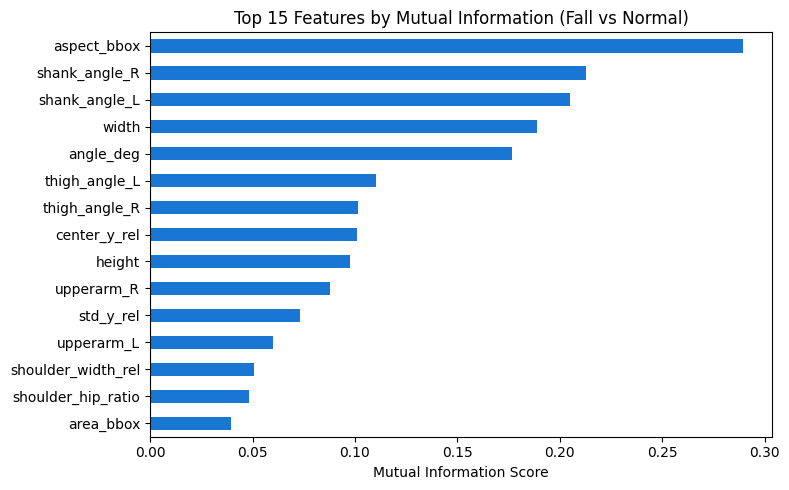

In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import pointbiserialr

# Preparar datos
X = df_sel.select_dtypes(include=[float, int]).drop(columns=["x_center", "y_center"], errors="ignore")  # opcional
y = df_sel["class_name"].map({"Normal": 0, "Fall": 1})

# --- 1️⃣ Point-Biserial Correlation ---
corr_scores = {}
for col in X.columns:
    corr, _ = pointbiserialr(X[col], y)
    corr_scores[col] = abs(corr)
corr_df = pd.DataFrame.from_dict(corr_scores, orient="index", columns=["pointbiserial_corr"])

# --- 2️⃣ ANOVA F-test ---
f_values, p_values = f_classif(X, y)
anova_df = pd.DataFrame({"f_value": f_values, "p_value": p_values}, index=X.columns)

# --- 3️⃣ Mutual Information ---
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({"mutual_info": mi_scores}, index=X.columns)

# --- Combine all rankings ---
feat_rank = corr_df.join(anova_df).join(mi_df)
feat_rank = feat_rank.sort_values("mutual_info", ascending=False)

# --- Display top features ---
print("Top features ranked by Mutual Information:")
display(feat_rank.head(15))

# --- Visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
feat_rank["mutual_info"].sort_values(ascending=True).tail(15).plot(kind="barh", color="#1976D2")
plt.title("Top 15 Features by Mutual Information (Fall vs Normal)")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()


In [34]:
# Detectar columnas constantes (sin variación)
X = df_sel.select_dtypes(include=[float, int]).copy()
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
print("Constant cols:", const_cols)

# Eliminar si existen
df_sel = df_sel.drop(columns=const_cols)


Constant cols: ['num_kp', 'num_kp_vis']


In [35]:
import numpy as np
import pandas as pd

# Partimos del ranking ya calculado: feat_rank con columna 'mutual_info'
Xall = df_sel.select_dtypes(include=[float, int]).copy()
y = df_sel["class_name"].map({"Normal":0,"Fall":1})

# (opcional) despriorizar medidas de escala absoluta en favor de ratios/ángulos
deprioritize = {"width","height","area_bbox"}
ranked = [f for f in feat_rank.index if f in Xall.columns]
ranked = sorted(ranked, key=lambda f: (f in deprioritize, -feat_rank.loc[f,"mutual_info"]))

# Greedy sin colinealidad
selected = []
corr_all = Xall.corr().abs()
for f in ranked:
    if all(corr_all.loc[f, s] < 0.85 for s in selected):
        selected.append(f)
    if len(selected) >= 15:   # ajusta tamaño final (10–20 es razonable)
        break

print("Selected (greedy, no-colinearity):", selected)


Selected (greedy, no-colinearity): ['aspect_bbox', 'shank_angle_R', 'shank_angle_L', 'angle_deg', 'thigh_angle_L', 'center_y_rel', 'upperarm_R', 'std_y_rel', 'upperarm_L', 'shoulder_width_rel', 'shoulder_hip_ratio', 'body_len_est', 'std_x_rel', 'shoulder_width', 'pose_area']


=== Logistic Regression (balanced) ===
              precision    recall  f1-score   support

      Normal       0.83      0.86      0.84       602
        Fall       0.83      0.79      0.81       520

    accuracy                           0.83      1122
   macro avg       0.83      0.83      0.83      1122
weighted avg       0.83      0.83      0.83      1122



<Figure size 640x480 with 0 Axes>

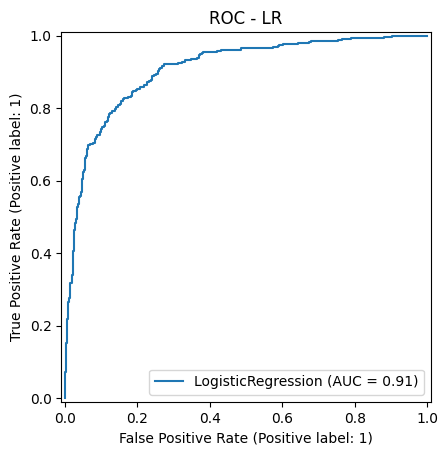

Threshold (recall≥0.90): 0.27779464239866414
              precision    recall  f1-score   support

      Normal       0.90      0.74      0.81       602
        Fall       0.75      0.90      0.82       520

    accuracy                           0.82      1122
   macro avg       0.83      0.82      0.82      1122
weighted avg       0.83      0.82      0.82      1122

=== XGBoost ===
              precision    recall  f1-score   support

      Normal       0.90      0.90      0.90       602
        Fall       0.89      0.88      0.88       520

    accuracy                           0.89      1122
   macro avg       0.89      0.89      0.89      1122
weighted avg       0.89      0.89      0.89      1122



<Figure size 640x480 with 0 Axes>

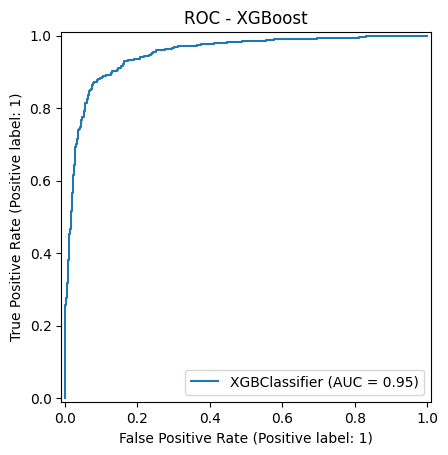

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

X = df_sel[selected].copy()
y = df_sel["class_name"].map({"Normal":0,"Fall":1})

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Modelo lineal (explicable) ----
scaler = StandardScaler().fit(X_tr)
Xtr_s, Xte_s = scaler.transform(X_tr), scaler.transform(X_te)

lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(Xtr_s, y_tr)
print("=== Logistic Regression (balanced) ===")
print(classification_report(y_te, lr.predict(Xte_s), target_names=["Normal","Fall"]))

plt.figure(); RocCurveDisplay.from_estimator(lr, Xte_s, y_te); plt.title("ROC - LR"); plt.show()

# Umbral para priorizar recall de caídas
proba = lr.predict_proba(Xte_s)[:,1]
fpr, tpr, thr = roc_curve(y_te, proba)
# ejemplo: elegir umbral que alcance recall >= 0.90 con la mayor precisión posible
import itertools
candidates = [(rec, 1-fp, th) for rec, fp, th in zip(tpr, fpr, thr) if rec >= 0.90]
thr_opt = max(candidates, key=lambda z: z[1])[2] if candidates else 0.5
print("Threshold (recall≥0.90):", thr_opt)
yhat = (proba >= thr_opt).astype(int)
print(classification_report(y_te, yhat, target_names=["Normal","Fall"]))

# ---- Modelo no lineal (robusto) ----
xgb = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
)
xgb.fit(X_tr, y_tr)
print("=== XGBoost ===")
print(classification_report(y_te, xgb.predict(X_te), target_names=["Normal","Fall"]))
plt.figure(); RocCurveDisplay.from_estimator(xgb, X_te, y_te); plt.title("ROC - XGBoost"); plt.show()


In [37]:
# --- Cross-Validation: LR y XGBoost ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

from xgboost import DMatrix, train as xgb_train

# Preparar X, y y features
if 'selected' in globals():
    feat_cols = selected
else:
    # fallback: usa todas las columnas numéricas excepto identificadores
    protect = {"x_center","y_center"}  # opcional
    feat_cols = [c for c in df_sel.select_dtypes(include=[float,int]).columns if c not in protect]

X = df_sel[feat_cols].copy()
y = df_sel["class_name"].map({"Normal":0,"Fall":1}).values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def metrics_from(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    p,r,f1,_ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    return acc,p,r,f1,auc

# ---- 1A) Logistic Regression (con StandardScaler dentro del pipeline)
lr_metrics = []
for tr_idx, te_idx in kf.split(X, y):
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y[tr_idx], y[te_idx]

    lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
    ])
    lr_pipe.fit(Xtr, ytr)
    prob = lr_pipe.predict_proba(Xte)[:,1]
    lr_metrics.append(metrics_from(yte, prob, thr=0.5))

lr_metrics = np.array(lr_metrics)
print("LR 5-fold — mean±std")
print("Accuracy   :", lr_metrics[:,0].mean().round(3), "±", lr_metrics[:,0].std().round(3))
print("Precision  :", lr_metrics[:,1].mean().round(3), "±", lr_metrics[:,1].std().round(3))
print("Recall(Fall):", lr_metrics[:,2].mean().round(3), "±", lr_metrics[:,2].std().round(3))
print("F1(Fall)   :", lr_metrics[:,3].mean().round(3), "±", lr_metrics[:,3].std().round(3))
print("AUC        :", lr_metrics[:,4].mean().round(3), "±", lr_metrics[:,4].std().round(3))

# ---- 1B) XGBoost (API nativa con DMatrix; compatible 2.x)
xgb_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    max_depth=4,
    eta=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)

xgb_metrics = []
for tr_idx, te_idx in kf.split(X, y):
    dtr = DMatrix(X.iloc[tr_idx], label=y[tr_idx], feature_names=feat_cols)
    dte = DMatrix(X.iloc[te_idx],  label=y[te_idx], feature_names=feat_cols)
    booster = xgb_train(
        params=xgb_params,
        dtrain=dtr,
        num_boost_round=1000,
        evals=[(dtr,"train")],
        verbose_eval=False
    )
    prob = booster.predict(dte)
    xgb_metrics.append(metrics_from(y[te_idx], prob, thr=0.5))

xgb_metrics = np.array(xgb_metrics)
print("\nXGB 5-fold — mean±std")
print("Accuracy   :", xgb_metrics[:,0].mean().round(3), "±", xgb_metrics[:,0].std().round(3))
print("Precision  :", xgb_metrics[:,1].mean().round(3), "±", xgb_metrics[:,1].std().round(3))
print("Recall(Fall):", xgb_metrics[:,2].mean().round(3), "±", xgb_metrics[:,2].std().round(3))
print("F1(Fall)   :", xgb_metrics[:,3].mean().round(3), "±", xgb_metrics[:,3].std().round(3))
print("AUC        :", xgb_metrics[:,4].mean().round(3), "±", xgb_metrics[:,4].std().round(3))


LR 5-fold — mean±std
Accuracy   : 0.844 ± 0.011
Precision  : 0.847 ± 0.018
Recall(Fall): 0.812 ± 0.017
F1(Fall)   : 0.829 ± 0.011
AUC        : 0.916 ± 0.01

XGB 5-fold — mean±std
Accuracy   : 0.912 ± 0.005
Precision  : 0.915 ± 0.01
Recall(Fall): 0.894 ± 0.002
F1(Fall)   : 0.904 ± 0.005
AUC        : 0.963 ± 0.007


In [38]:
# --- Train final con early stopping y exportación ---
from sklearn.model_selection import train_test_split
from xgboost import DMatrix, train as xgb_train
from google.colab import drive
import json, os

drive.mount('/content/drive')

EXPORT_DIR = "/content/drive/MyDrive/Colab Notebooks/Integrador/fall_opp"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Usa todo tu set (o combina train+valid si ya los separaste)
X_all = df_sel[feat_cols].copy()
y_all = df_sel["class_name"].map({"Normal":0,"Fall":1}).values

# Pequeño hold-out interno (10%) para early stopping
X_tr, X_va, y_tr, y_va = train_test_split(X_all, y_all, test_size=0.10, stratify=y_all, random_state=123)

dtr = DMatrix(X_tr, label=y_tr, feature_names=feat_cols)
dva = DMatrix(X_va, label=y_va, feature_names=feat_cols)

params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    max_depth=4,
    eta=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)

evals = [(dtr,"train"), (dva,"valid")]
booster = xgb_train(
    params=params,
    dtrain=dtr,
    evals=evals,
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Best iteration:", booster.best_iteration)
print("Best AUC(valid):", booster.best_score)

# Umbral orientado a recall(Fall) en la valid interna
from sklearn.metrics import roc_curve
proba_va = booster.predict(dva)
fpr,tpr,thr = roc_curve(y_va, proba_va)
cands = [(rec, 1-fp, th) for rec, fp, th in zip(tpr, fpr, thr) if rec >= 0.90]
thr_opt = max(cands, key=lambda z: z[1])[2] if cands else 0.5
print("Chosen threshold (valid-internal, recall≥0.90):", thr_opt)

# Export
model_path = f"{EXPORT_DIR}/posture_clf_xgb.json"
meta_path  = f"{EXPORT_DIR}/posture_clf_meta.json"

booster.save_model(model_path)
meta = {
    "model_type": "XGBoost",
    "features_used": feat_cols,
    "threshold": float(thr_opt),
    "best_iteration": int(booster.best_iteration),
    "best_auc_valid": float(booster.best_score)
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Exported:")
print("-", model_path)
print("-", meta_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best iteration: 971
Best AUC(valid): 0.9622412471249681
Chosen threshold (valid-internal, recall≥0.90): 0.48975083
✅ Exported:
- /content/drive/MyDrive/Colab Notebooks/Integrador/fall_opp/posture_clf_xgb.json
- /content/drive/MyDrive/Colab Notebooks/Integrador/fall_opp/posture_clf_meta.json
